In [21]:
import pandas as pd

router_timestamp = pd.read_csv('C:\\Users\\zhengqiushi\\Desktop\\hik\\21-08-13\\数据\\t_alarm_router_timestamp_.csv')

# 时间段划分间隔
time_windows = 12*3600

iter_num = 0

# 组合（道路偏移）
lane_offset = [132356 ,
               132358 ]
lane_offset_warning = [132355 , 132357]

seq_length_thresh = 1

# 重新赋值成的
lane_offset_uniform_id = 10000
lane_offset_warning_uniform_id = 10001

time_seq = []
new_array_timestamp = []
new_array_event_type = []

# 取出所有的router_id
router_id = router_timestamp.groupby('router_id').head(1)["router_id"].values
router_id.sort()

for index, cur_id in enumerate(router_id):
    # 遍历每一条行程
    tmp_df = router_timestamp[router_timestamp["router_id"] == cur_id]
    for i,r in tmp_df.iterrows():
        # 遍历在每一条行程内的每一个alarm
        cur_time = pd.to_datetime(r['begin_time'])
        cur_event = r['event_type']

        # 重新赋值左偏右偏
        if cur_event in lane_offset:
            cur_event = lane_offset_uniform_id
        elif cur_event in lane_offset_warning:
            cur_event = lane_offset_warning_uniform_id

        if len(new_array_timestamp) == 0:
            # 新序列的第一个
            new_array_timestamp.append(cur_time)
            new_array_event_type.append(cur_event)
        else:
            # 后续是否要加入
            delta_time = cur_time - new_array_timestamp[-1]
            
            if delta_time.total_seconds() < time_windows: 
                
                # 仍在时间段内
                last_event = new_array_event_type[-1]
                if  cur_event != last_event:
                    # 连续的去重
                    # if len(time_seq) == 2027:
                    #     print(cur_event, delta_time.total_seconds(), cur_time, new_array_timestamp[-1])

                    new_array_timestamp.append(cur_time)
                    new_array_event_type.append(cur_event)
            else:
                # 超出时间阈值，成为新的序列
                if len(new_array_event_type) > seq_length_thresh:
                    time_seq.append((cur_id, new_array_event_type.copy()))
                
                new_array_event_type.clear()
                new_array_timestamp.clear()

        iter_num = iter_num + 1
        

    if len(new_array_timestamp) > 0:
        time_seq.append((cur_id, new_array_event_type.copy()))
        new_array_event_type.clear()
        new_array_timestamp.clear()

    
# print(time_seq[2027])
# print(tmp_df)

In [22]:
print(len(time_seq), len(router_id))

352 352


In [23]:
risk_type_df = pd.read_csv('C:\\Users\\zhengqiushi\\Desktop\\hik\\21-08-13\\数据\\t_alarm_basic_config' + '.csv')


def return_type_name(type_id):
    '''
    @breif id->name
    '''
    if type_id == lane_offset_uniform_id:
        return "车道偏离" 
    elif type_id == lane_offset_warning_uniform_id:
        return "车道偏离预警" 
    else: 
        return risk_type_df[risk_type_df['event_type'] == type_id]['\"name\"'].values[0]


def return_type_id(type_name):
    '''
    @breif name->id
    '''
    if type_name == "车道偏离":
        return lane_offset_uniform_id
    elif type_name == "车道偏离预警":
        return lane_offset_warning_uniform_id
    else: 
        return risk_type_df[risk_type_df['\"name\"'] == type_name]['event_type'].values[0]


print(return_type_name(132355))
print(return_type_id("车道偏离预警"))

车道偏离（左）预警
10001


In [24]:
from prefixspan import PrefixSpan

result_seq = []
def cover(patt, matches):
    '''
    @brief 序列挖掘筛选函数
    '''
    is_same = False # True
    # 序列长度
    if len(patt) > 0:
        first = ""
        for i, per_patt in enumerate(patt):
            if i == 0:
                continue
            else:
                if patt[i - 1] == patt[i]:
                    is_same = True
                    break
            # 保证不是单个动作重复的序列，遍历每一个
            # if first == "":
            #     first = i
            # if first != i:
            #     is_same = False
            #     break
    if is_same == False and len(matches) > 3:
        # 匹配阈值
        patt_with_name = []
        for i in patt:
            patt_with_name.append(return_type_name(i))
        # 将id换成name
        result_seq.append((len(matches), patt_with_name))


# print(time_seq[1][1])
time_seq_pure = []
for i in time_seq:
    time_seq_pure.append(i[1])
# print(time_seq_pure)

ps = PrefixSpan(time_seq_pure)

ps.topk(1000, callback=cover)
# print(type(ps.topk(5, filter=lambda patt, matches: len(patt) > 1)[0]))





In [25]:
# print(time_seq)
# print(result_seq)
import functools


def my_compare(x,y):
    len_x = len(x[1])
    len_y = len(y[1])

    if len_x < len_y:
        return -1
    elif len_x == len_y:
        if x[0] > y[0]:
            return -1
        else:
            return 1
    else: 
        return 1
 
#分别使用sorted和list.sort
# print(result_seq)
# print()
result_seq = sorted(result_seq,key=functools.cmp_to_key(my_compare))

In [26]:
import numpy as np
def diff_array(new_seq, old_seq):
    new_seq = np.array(new_seq[1])
    old_seq = np.array(old_seq[1])

    return list(set(new_seq).difference(set(old_seq)))

def is_covered(new_seq, old_seq):

    new_seq = np.array(new_seq[1])
    old_seq = np.array(old_seq[1])

    new_ptr = 0
    old_ptr = 0

    while new_ptr < len(new_seq) and old_ptr < len(old_seq):
        if new_seq[new_ptr] == old_seq[old_ptr]:
            new_ptr += 1
            old_ptr += 1
        else:
            new_ptr += 1
    
    return (old_ptr == len(old_seq))

filter_res = []
# 近似认为 new_seq 长度比 old_seq 长
for new_seq in result_seq:
    
    if len(filter_res) == 0:
        filter_res.append(new_seq)
    else:
        is_covered_flag = False
        for old_seq in filter_res:
            # 旧的内容是否能够完全覆盖（但是需要仍然有序！不能直接做差集！）
            # 信息量
            diff_set = diff_array(new_seq, old_seq)
            # 子序列
            is_covered_flag = is_covered(new_seq, old_seq)

            if is_covered_flag and len(diff_set) == 0: # 
                # 信息没增加且完全被之前的子序列包含
                is_covered_flag = True
                break
        if is_covered_flag == False:
            filter_res.append(new_seq)


def my_compare(x,y):
    if x[0] > y[0]:
        return -1
    else:
        return 1
 
#分别使用sorted和list.sort
filter_res = sorted(filter_res,key=functools.cmp_to_key(my_compare))


filter_res_id = []
print(len(filter_res))
for i in filter_res:
    per_arr = []
    for j in i[1]:
        per_arr.append(return_type_id(j))
    filter_res_id.append(per_arr)
    # print(i)
    
# print(filter_res)



31


In [27]:
# # 匹配模板 filter_res filter_res_id
# # time_seq
from matplotlib.font_manager import FontProperties 
from matplotlib import pyplot as plt

font = FontProperties(fname=r"C:\\Windows\\Fonts\\simsun.ttc", size=15) 

plt.figure(figsize=(20,5))

arr = []



filter_res_str = []
for index, i in enumerate(filter_res):
    cur_str = ""
    # if index > 10:
    #     break
    for j in i[1]:
        cur_str += str(j) + ","
    filter_res_str.append(cur_str)



filter_res_id_str = []
for index, i in enumerate(filter_res_id):
    cur_str = ""
    # if index > 10:
    #     break
    for j in i:
        cur_str += str(j) + ","
    filter_res_id_str.append(cur_str)

# print(filter_res_id_str)



time_seq_str = []
for index, i in enumerate(time_seq):
    cur_str = ""
    # if index > 10:
    #     break
    for j in i[1]:
        cur_str += str(j) + ","
    time_seq_str.append(cur_str)

# print(time_seq_str)

# 遍历每种alarm event
data = {}
for i in filter_res_str:
    data[i] = []

# print(filter_res)
# print(filter_res_str)


<Figure size 1440x360 with 0 Axes>

In [28]:
def seq_find(real_seq, sub_seq):
    cnt = 0
    is_find = True
    if len(real_seq) < len(sub_seq):
        is_find = False
    else:
        
        cur_pos = 0
        while(1):
            cur_pos = seq_find_iter(cur_pos, 0, real_seq, sub_seq)
            # print("out: ", cur_pos, real_seq[cur_pos])
            if cur_pos == -1:
                break
            cnt += 1
            # cur_pos += 1
            #if cnt > 20:
            #   break
    return cnt

def seq_find_iter(i, j, real_seq, sub_seq):
    n = len(real_seq)
    m = len(sub_seq)
    real_ptr = i
    sub_ptr = j
    while(m - j <= n - i):
        # real剩下的比sub还要少
        if j > m - 1:
            # print("ok")
            return i
        if real_seq[i] == sub_seq[j]:
            # 匹配成功共同进一
            # print(i , real_seq[i])
            i += 1
            j += 1
        else:
            i += 1
    return -1

print(seq_find("babgbagbbbbaaaaagggg", "bag"))



3


9 10000,10001,10000,10001,10000,10001,10000,10001,10000,10001,132359,10001,10000,132360,10000,10001,10000,10001,10000,132372,10001,132372,10001,132372,
21 10001,10000,132360,10000,132360,10000,132360,10000,132360,10000,132360,10000,132360,10000,10001,10000,132360,10000,132360,10000,132360,10000,10001,
26 10001,10000,10001,132360,10000,132360,10000,132359,10001,132353,132359,10001,10000,132360,132359,10001,10000,10001,132353,10001,10000,10001,10000,132359,10001,
31 10001,132359,10001,132360,10000,10001,132360,10000,132360,132359,10000,132360,132354,132360,132353,10001,132359,10001,10000,132360,132359,132360,132359,10001,10000,132359,10001,
32 132359,132353,132360,10000,132360,132359,10000,132360,10001,132359,10000,132360,132359,10001,10000,132359,132360,10000,132360,10000,132360,132359,132360,132354,132360,132354,132360,132354,132360,10000,132360,132354,132360,10001,132359,10001,132360,10000,132354,132353,10000,10001,10000,10001,10000,132360,10000,10001,10000,132359,10001,10000,10001,13

C:\Users\zhengqiushi\AppData\Local\Temp/ipykernel_9236/3362136005.py:26: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df_final_data.describe().T.to_excel('C:\\Users\\zhengqiushi\\Desktop\\hik\\21-08-13\\数据\\task5_stastics.xls')


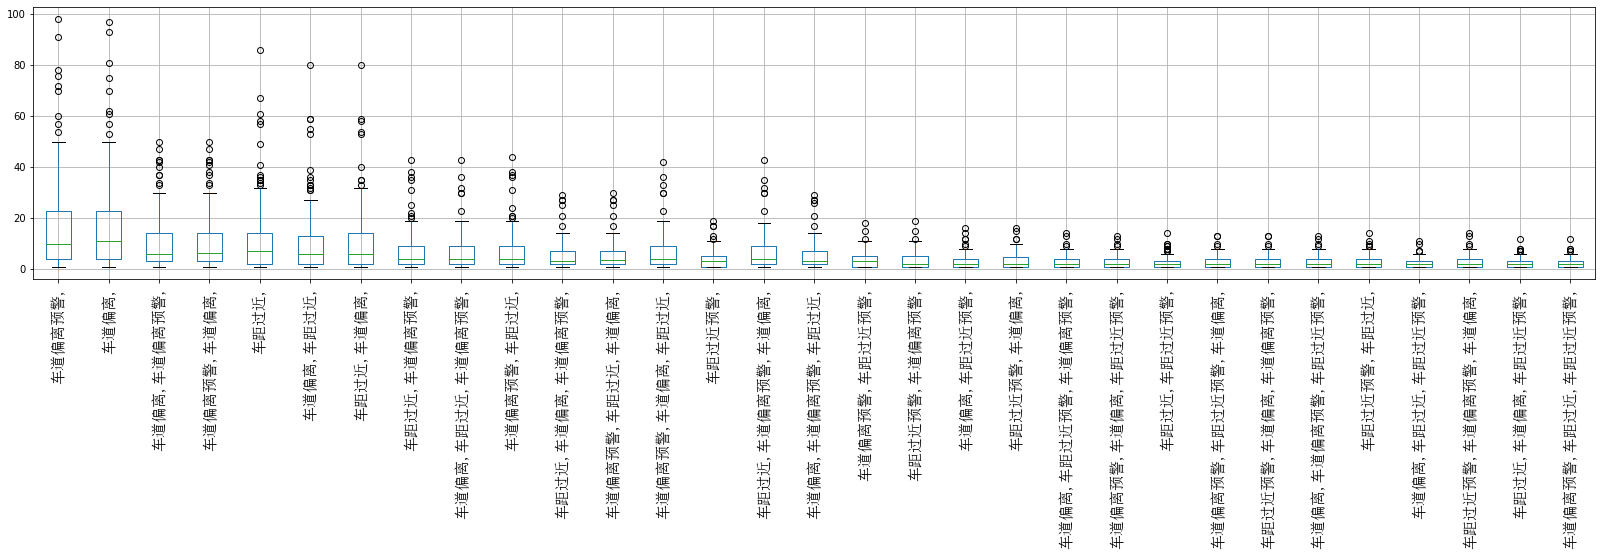

In [29]:
# 一旦出现，出现的频率
# 匹配方法不太科学
for index, record in enumerate(time_seq_str):
    for patt_index, patt in enumerate(filter_res_id_str):
        # arr[patt_index].append(record.count(patt))
        # if record.count(patt) != 0:

        data[filter_res_str[patt_index]].append(seq_find(record, patt)) # record.count(patt))

filter_data = {}
for patt_index, patt in enumerate(filter_res_id_str):
    patt_str = filter_res_str[patt_index]
    if len(data[patt_str]) > 0:
        filter_data[patt_str] = data[patt_str]
# print(data)

# 补齐
df_final_data = pd.DataFrame.from_dict(filter_data, orient='index')
df_final_data = df_final_data[df_final_data != 0]

df_final_data = df_final_data.T

print(df_final_data.describe())

df_final_data.describe().T.to_excel('C:\\Users\\zhengqiushi\\Desktop\\hik\\21-08-13\\数据\\task5_stastics.xls')
plt.figure(figsize=(28,5))
# 解决标注乱码的问题
ax = df_final_data.boxplot(rot='90')
for label in ax.get_xticklabels() : 
    label.set_fontproperties(font) 